# Final Highway Network Experiment Analysis
This one uses the increase_ego_reward_importance setting

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob 
import os
import matplotlib.pyplot as plt
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from src.utils import calc_hypervolume

## Loading the data

In [2]:
def load_merged_dataframe(literal_str):
    file_list = glob.glob(literal_str)
    df = pd.concat(map(pd.read_csv, file_list), ignore_index=True)
    return df

In [3]:
#load the data
#first two configs
summary_files = os.path.join("data/moma_highway_test_final_alternative_mean_reward_structure/", "moma_highway_test_final_alternative_mean_reward_structure*summary.csv")
detail_files = os.path.join("data/moma_highway_test_final_alternative_mean_reward_structure/", "moma_highway_test_final_alternative_mean_reward_structure*detail.csv")
loss_files = os.path.join("data/moma_highway_test_final_alternative_mean_reward_structure/", "moma_highway_test_final_alternative_mean_reward_structure*loss.csv")

df_summary = load_merged_dataframe(summary_files)
df_detail = load_merged_dataframe(detail_files)
df_loss = load_merged_dataframe(loss_files)

In [4]:
print("Summary:")
df_summary.info()
print("Detail:")
df_detail.info()
print("Loss")
df_loss.info()

Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57600 entries, 0 to 57599
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      57600 non-null  int64  
 1   repetition_number               57600 non-null  int64  
 2   weight_index                    57600 non-null  int64  
 3   weight_tuple                    57600 non-null  object 
 4   num_iterations                  57600 non-null  int64  
 5   vehicle_id                      57600 non-null  int64  
 6   normalised_speed_reward         57600 non-null  float64
 7   normalised_energy_reward        57600 non-null  float64
 8   raw_speed_reward                57600 non-null  float64
 9   raw_energy_reward               57600 non-null  float64
 10  env_config_id                   57600 non-null  int64  
 11  experiment_id                   57600 non-null  int64  
 12  replay_buffer_size     

## Data Preprocessing

In [5]:
def add_cv_ratio(df):
    df["controlled_vehicle_ratio"] = 0.0
    df.loc[df["env_config_id"] == 0, "controlled_vehicle_ratio"] = 2/20
    df.loc[df["env_config_id"] == 1, "controlled_vehicle_ratio"] = 8/20
    df.loc[df["env_config_id"] == 2, "controlled_vehicle_ratio"] = 14/20
    return df

def shorten_reward_structure_names(df):
    #exclude the suffix "reward" for entries the reward structure column
    df["reward_structure"] = df["reward_structure"].apply(lambda row: row.split("_")[0])

    #remap the use_multi_dqn column to explicitly state the employed reward structure
    df["use_multi_dqn"] = df["use_multi_dqn"].astype(str)
    df.loc[df["use_multi_dqn"] == "False","use_multi_dqn"] = "basic"
    df.loc[df["use_multi_dqn"] == "True","use_multi_dqn"] = "separated"
    return df

def add_config_names(df):
    df["alg_config"] = df.apply(lambda row : f"NS_{row["use_multi_dqn"]}_RS_{row["reward_structure"]}", axis=1)
    print(df["alg_config"].value_counts())

    df["exp_config"] = df.apply(lambda row : f"CVR_{row["controlled_vehicle_ratio"]}_NS_{row["use_multi_dqn"]}_RS_{row["reward_structure"]}", axis=1)
    print(df["exp_config"].value_counts())

    return df

def extend_dataframe(df):
    df = add_cv_ratio(df)
    df = shorten_reward_structure_names(df)
    df = add_config_names(df)
    return df

In [6]:
df_summary = extend_dataframe(df_summary)
df_detail = extend_dataframe(df_detail)
df_loss = extend_dataframe(df_loss)
df_summary["controlled_vehicle_ratio"].value_counts()

alg_config
NS_basic_RS_ego         19200
NS_separated_RS_mean    19200
NS_basic_RS_mean        19200
Name: count, dtype: int64
exp_config
CVR_0.7_NS_basic_RS_ego         11200
CVR_0.7_NS_separated_RS_mean    11200
CVR_0.7_NS_basic_RS_mean        11200
CVR_0.4_NS_basic_RS_ego          6400
CVR_0.4_NS_basic_RS_mean         6400
CVR_0.4_NS_separated_RS_mean     6400
CVR_0.1_NS_separated_RS_mean     1600
CVR_0.1_NS_basic_RS_mean         1600
CVR_0.1_NS_basic_RS_ego          1600
Name: count, dtype: int64
alg_config
NS_separated_RS_mean    3485120
NS_basic_RS_mean        3345240
NS_basic_RS_ego         3046840
Name: count, dtype: int64
exp_config
CVR_0.1_NS_separated_RS_mean    1214760
CVR_0.7_NS_separated_RS_mean    1180800
CVR_0.4_NS_basic_RS_mean        1155280
CVR_0.7_NS_basic_RS_ego         1105200
CVR_0.7_NS_basic_RS_mean        1100320
CVR_0.1_NS_basic_RS_mean        1089640
CVR_0.4_NS_separated_RS_mean    1089560
CVR_0.1_NS_basic_RS_ego         1025040
CVR_0.4_NS_basic_RS_ego       

controlled_vehicle_ratio
0.7    33600
0.4    19200
0.1     4800
Name: count, dtype: int64

In [7]:
#exclude the suffix "reward" for entries the reward structure column
df_summary["reward_structure"] = df_summary["reward_structure"].apply(lambda row: row.split("_")[0])

#remap the use_multi_dqn column to explicitly state the employed reward structure
df_summary["use_multi_dqn"] = df_summary["use_multi_dqn"].astype(str)
df_summary.loc[df_summary["use_multi_dqn"] == "False","use_multi_dqn"] = "basic"
df_summary.loc[df_summary["use_multi_dqn"] == "True","use_multi_dqn"] = "separated"

In [8]:
print(df_summary["reward_structure"].value_counts())
print(df_summary["use_multi_dqn"].value_counts())

reward_structure
mean    38400
ego     19200
Name: count, dtype: int64
use_multi_dqn
basic        38400
separated    19200
Name: count, dtype: int64


In [9]:
# add experiment configuration name
df_summary["alg_config"] = df_summary.apply(lambda row : f"NS_{row["use_multi_dqn"]}_RS_{row["reward_structure"]}", axis=1)
print(df_summary["alg_config"].value_counts())

df_summary["exp_config"] = df_summary.apply(lambda row : f"CVR_{row["controlled_vehicle_ratio"]}_NS_{row["use_multi_dqn"]}_RS_{row["reward_structure"]}", axis=1)
print(df_summary["exp_config"].value_counts())

alg_config
NS_basic_RS_ego         19200
NS_separated_RS_mean    19200
NS_basic_RS_mean        19200
Name: count, dtype: int64
exp_config
CVR_0.7_NS_basic_RS_ego         11200
CVR_0.7_NS_separated_RS_mean    11200
CVR_0.7_NS_basic_RS_mean        11200
CVR_0.4_NS_basic_RS_ego          6400
CVR_0.4_NS_basic_RS_mean         6400
CVR_0.4_NS_separated_RS_mean     6400
CVR_0.1_NS_separated_RS_mean     1600
CVR_0.1_NS_basic_RS_mean         1600
CVR_0.1_NS_basic_RS_ego          1600
Name: count, dtype: int64


## Data Analysis

### Pareto front estimation

Text(0.5, 0, 'Normalised Speed Reward')

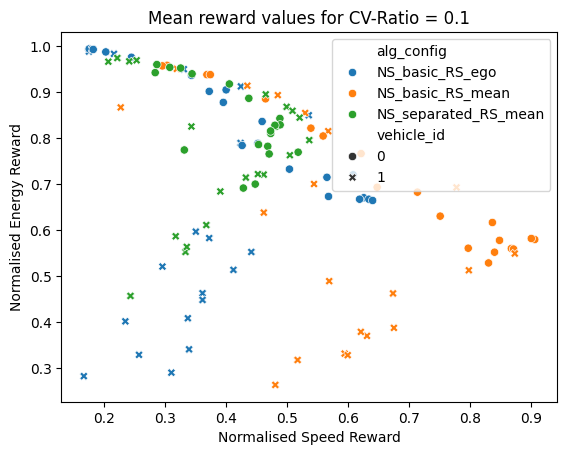

In [10]:
grouped_df = df_summary[df_summary["controlled_vehicle_ratio"]==0.1].groupby(["alg_config","weight_index", "vehicle_id"])[["normalised_energy_reward", "normalised_speed_reward"]].mean()
ax = sns.scatterplot(grouped_df, x="normalised_speed_reward", y="normalised_energy_reward", style="vehicle_id",hue="alg_config")
ax.set_title("Mean reward values for CV-Ratio = 0.1")
ax.set_ylabel("Normalised Energy Reward")
ax.set_xlabel("Normalised Speed Reward")

This plot shows how for this specific cv ratio, the baseline algorithm does best, supposedly because they only care about their own reward. For the mean algo's on the other hand, the vehicle rewards have a lower variance because they care about the rewards of other vehicles as well. If that first impression holds, we will see when looking at the boxplots.

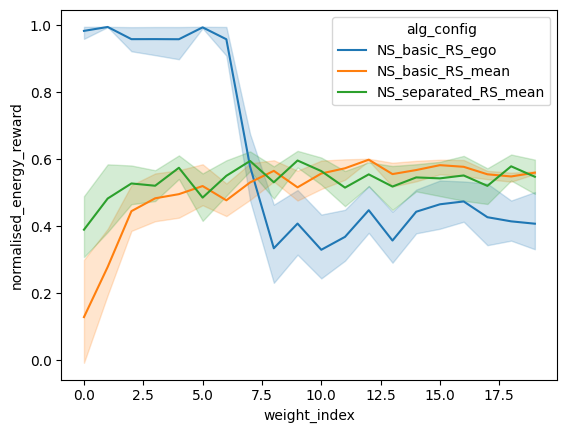

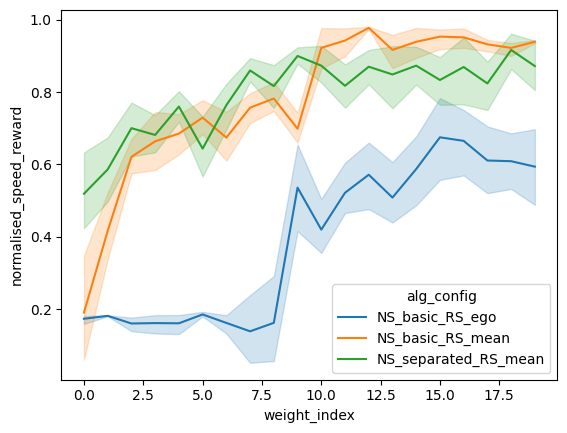

In [11]:
#TODO: two lineplots: one for the energy reward, one for the speeds reward chosing how they change when increasing the preference for speed, i.e. weight index on the x-axis
grouped_df = df_summary[df_summary["controlled_vehicle_ratio"]==0.4].groupby(["alg_config","weight_index", "vehicle_id"])[["normalised_energy_reward","normalised_speed_reward"]].mean()
sns.lineplot(grouped_df, x="weight_index", y="normalised_energy_reward", hue="alg_config")
plt.show()
sns.lineplot(grouped_df, x="weight_index", y="normalised_speed_reward", hue="alg_config")
plt.show()

#0.4 ratio

The ego one does way better than the mean ones in producing very different policies when changing the preferences. This can be attributed to them not caring about other vehicles. The mean ones on the other hand have a much more subtle change in rewards when changing the weight index. This might be caused by several factors. First off, they care about the other vehicle's returns, so they might use different actions because it would increase the mean utility for the close vehicles. Interestingly, when increasing the ratio of vehicles that are controlled to 0.7, the ego algorithm behaves the same, which might be because the controlled vehicles are actually impeding with each other, everyone trying to get out on top (indicated by the high variation is speeds), while the variance for the mean algorithms, the mean separated one in particular, are much lower. This indicates that is has an easier time accurately assessing the social q-values for the close vehicles.

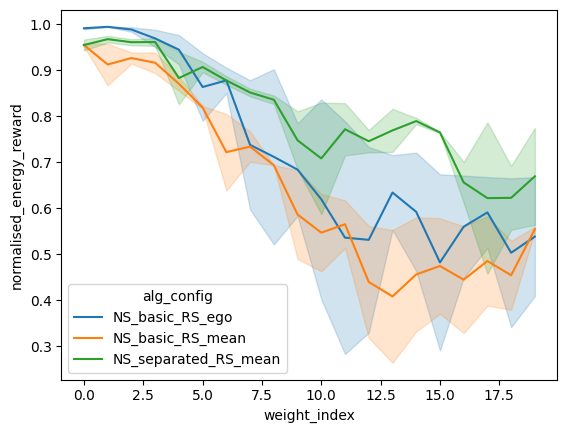

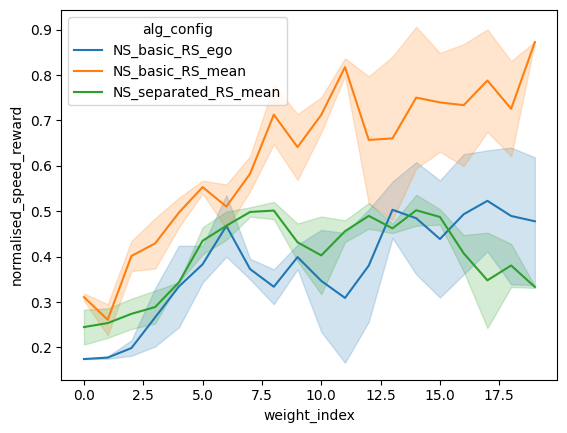

In [12]:
grouped_df = df_summary[df_summary["controlled_vehicle_ratio"]==0.1].groupby(["alg_config","weight_index", "vehicle_id"])[["normalised_energy_reward","normalised_speed_reward"]].mean()
sns.lineplot(grouped_df, x="weight_index", y="normalised_energy_reward", hue="alg_config")
plt.show()
sns.lineplot(grouped_df, x="weight_index", y="normalised_speed_reward", hue="alg_config")
plt.show()

#0.4 ratio

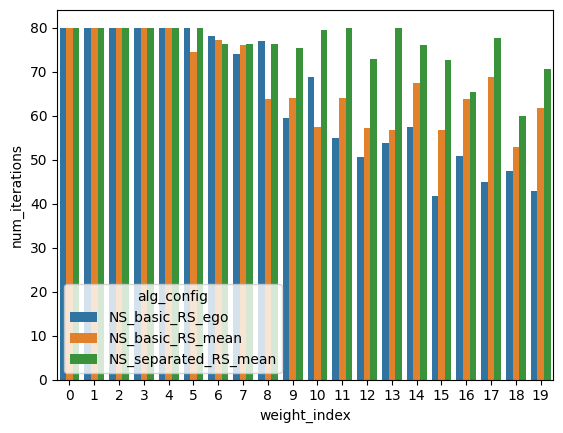

In [13]:
#TODO: num iterations before a crash
grouped_df = df_summary[df_summary["controlled_vehicle_ratio"]==0.1].groupby(["alg_config","weight_index", "vehicle_id"])[["num_iterations"]].mean()
sns.barplot(grouped_df, x="weight_index", y="num_iterations", hue="alg_config")
plt.show()

All approximately the same

### Plots of hypervolume distribution among vehicles of the same experiment

In [14]:
#compute hypervolume for all vehicles
hv_data = []
grouped_data = df_summary.groupby(["controlled_vehicle_ratio","alg_config","vehicle_id"])
for (cvr, alg_config, vehicle_id), group in grouped_data:
    group_data = group[["normalised_speed_reward","normalised_energy_reward"]].to_numpy()
    hv = calc_hypervolume(reward_vector=group_data)
    hv_data.append({"controlled_vehicle_ratio": cvr, "alg_config":alg_config, "vehicle_id": vehicle_id, "hypervolume":hv})

hv_df = pd.DataFrame(hv_data)
display(hv_df)
#TODO: construct scatterplot and then boxplot of the hypervolumes for the vehicles grouped by ratio of controlled vehicles and by reward/network structure
#compute hypervolume




Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False



,controlled_vehicle_ratio,alg_config,vehicle_id,hypervolume
0,0.1,NS_basic_RS_ego,0,0.758194
1,0.1,NS_basic_RS_ego,1,0.825447
2,0.1,NS_basic_RS_mean,0,0.824384
3,0.1,NS_basic_RS_mean,1,0.838026
4,0.1,NS_separated_RS_mean,0,0.622783
...,...,...,...,...
67,0.7,NS_separated_RS_mean,9,0.815578
68,0.7,NS_separated_RS_mean,10,0.824315
69,0.7,NS_separated_RS_mean,11,0.825942
70,0.7,NS_separated_RS_mean,12,0.829125


<Axes: xlabel='controlled_vehicle_ratio', ylabel='hypervolume'>

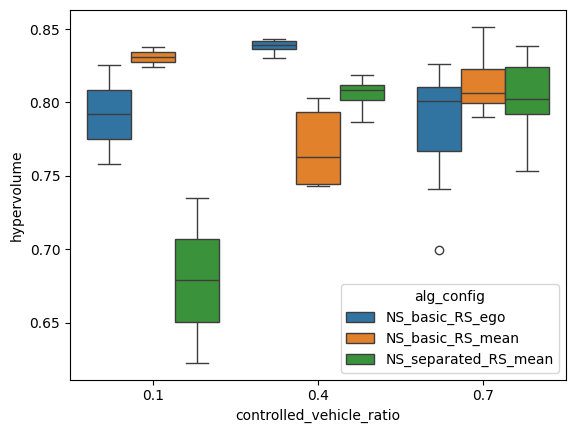

In [15]:
sns.boxplot(hv_df, x="controlled_vehicle_ratio", y="hypervolume", hue="alg_config")
#TODO: hypothesis: the hypervolume is dependent on the vehicle id, 
# because of they way they are spawned (one vehicle is always first, 
# has an easier time optimising their reward as they don't have as many vehicles to overtake): 
# color the dots in the scatterplot by the vehicle_id to see if there is. 
# If that is to messy to see something, try using a barplot/lineplot 
# with the vehicle ID on the x axis and the hypervolume on the y axis

<Axes: xlabel='vehicle_id', ylabel='hypervolume'>

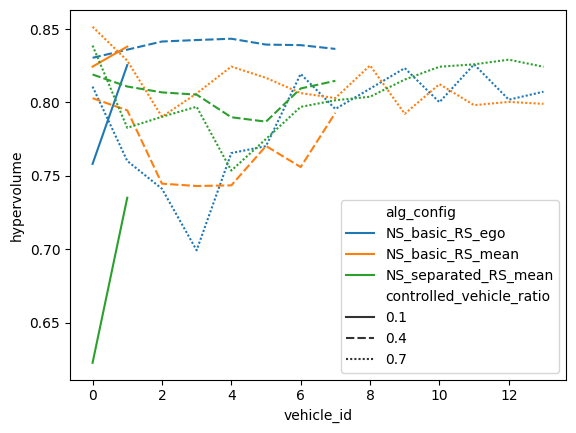

In [16]:
sns.lineplot(hv_df, x="vehicle_id", y="hypervolume", hue="alg_config", style="controlled_vehicle_ratio")

### Loss analysis

In [17]:
df_loss

,Unnamed: 0,episode,loss,hypervolume,avg_num_iterations_training,std_num_iterations_training,env_config_id,experiment_id,replay_buffer_size,batch_size,reward_structure,use_multi_dqn,observation_space_name,increase_ego_reward_importance,controlled_vehicle_ratio,alg_config,exp_config
0,0,0.0,0.301992,0.110747,77.13,14.107737,0,2,10000,100,mean,basic,OccupancyGrid,True,0.1,NS_basic_RS_mean,CVR_0.1_NS_basic_RS_mean
1,1,1.0,0.283854,NaN,NaN,NaN,0,2,10000,100,mean,basic,OccupancyGrid,True,0.1,NS_basic_RS_mean,CVR_0.1_NS_basic_RS_mean
2,2,2.0,0.285835,NaN,NaN,NaN,0,2,10000,100,mean,basic,OccupancyGrid,True,0.1,NS_basic_RS_mean,CVR_0.1_NS_basic_RS_mean
3,3,3.0,0.444172,NaN,NaN,NaN,0,2,10000,100,mean,basic,OccupancyGrid,True,0.1,NS_basic_RS_mean,CVR_0.1_NS_basic_RS_mean
4,4,4.0,0.567041,NaN,NaN,NaN,0,2,10000,100,mean,basic,OccupancyGrid,True,0.1,NS_basic_RS_mean,CVR_0.1_NS_basic_RS_mean
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,1995,1995.0,0.359071,NaN,NaN,NaN,0,3,10000,100,mean,separated,OccupancyGrid,True,0.1,NS_separated_RS_mean,CVR_0.1_NS_separated_RS_mean
35996,1996,1996.0,0.405837,NaN,NaN,NaN,0,3,10000,100,mean,separated,OccupancyGrid,True,0.1,NS_separated_RS_mean,CVR_0.1_NS_separated_RS_mean
35997,1997,1997.0,0.378753,NaN,NaN,NaN,0,3,10000,100,mean,separated,OccupancyGrid,True,0.1,NS_separated_RS_mean,CVR_0.1_NS_separated_RS_mean
35998,1998,1998.0,0.383637,NaN,NaN,NaN,0,3,10000,100,mean,separated,OccupancyGrid,True,0.1,NS_separated_RS_mean,CVR_0.1_NS_separated_RS_mean


In [18]:
#TODO: look at how the loss (and maybe the hypervolume) changes while training for all the algorithm configurations
grouped_df = df_loss.groupby(["alg_config", "controlled_vehicle_ratio", "episode"])["loss"].mean()
grouped_df = grouped_df.reset_index()
display(grouped_df)

,alg_config,controlled_vehicle_ratio,episode,loss
0,NS_basic_RS_ego,0.1,0.0,0.283939
1,NS_basic_RS_ego,0.1,1.0,0.312938
2,NS_basic_RS_ego,0.1,2.0,0.333868
3,NS_basic_RS_ego,0.1,3.0,0.509468
4,NS_basic_RS_ego,0.1,4.0,0.734152
...,...,...,...,...
17993,NS_separated_RS_mean,0.7,1995.0,1.286401
17994,NS_separated_RS_mean,0.7,1996.0,1.626066
17995,NS_separated_RS_mean,0.7,1997.0,1.357067
17996,NS_separated_RS_mean,0.7,1998.0,1.252091


<Axes: xlabel='episode', ylabel='loss'>

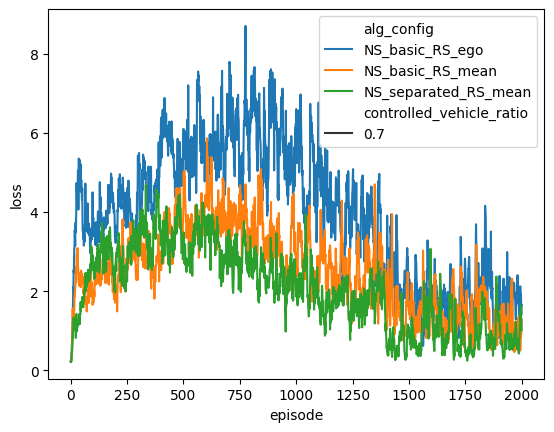

In [19]:
sns.lineplot(grouped_df[grouped_df["controlled_vehicle_ratio"] == 0.7], x="episode", y="loss", hue="alg_config", style="controlled_vehicle_ratio")

### Detail df analysis

In [20]:
df_detail["speed_diff"] = np.abs(df_detail["target_speed"] - df_detail["curr_speed"])
df_detail["abs_acc"] = np.abs(df_detail["acc"])
df_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9877200 entries, 0 to 9877199
Data columns (total 27 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   Unnamed: 0                      int64  
 1   repetition_number               int64  
 2   weight_index                    int64  
 3   weight_tuple                    object 
 4   iteration                       int64  
 5   vehicle_id                      int64  
 6   controlled_flag                 int64  
 7   action                          float64
 8   target_speed                    float64
 9   curr_speed                      float64
 10  acc                             float64
 11  lane                            int64  
 12  curr_speed_reward               float64
 13  curr_energy_reward              float64
 14  env_config_id                   int64  
 15  experiment_id                   int64  
 16  replay_buffer_size              int64  
 17  batch_size                 

In [30]:
grouped_df = df_detail.groupby(["alg_config","controlled_flag", "controlled_vehicle_ratio", "repetition_number","iteration"])["abs_acc"].mean()
grouped_df = grouped_df.reset_index()
display(grouped_df)

,alg_config,controlled_flag,controlled_vehicle_ratio,repetition_number,iteration,abs_acc
0,NS_basic_RS_ego,0,0.1,0,0,1.328560e+00
1,NS_basic_RS_ego,0,0.1,0,1,5.132383e-01
2,NS_basic_RS_ego,0,0.1,0,2,3.426379e-01
3,NS_basic_RS_ego,0,0.1,0,3,2.814219e-01
4,NS_basic_RS_ego,0,0.1,0,4,2.193255e-01
...,...,...,...,...,...,...
28795,NS_separated_RS_mean,1,0.7,19,75,1.722373e-08
28796,NS_separated_RS_mean,1,0.7,19,76,2.305557e-09
28797,NS_separated_RS_mean,1,0.7,19,77,3.158747e-10
28798,NS_separated_RS_mean,1,0.7,19,78,4.561804e-11


### uncontrolled vehicles

<Axes: xlabel='iteration', ylabel='abs_acc'>

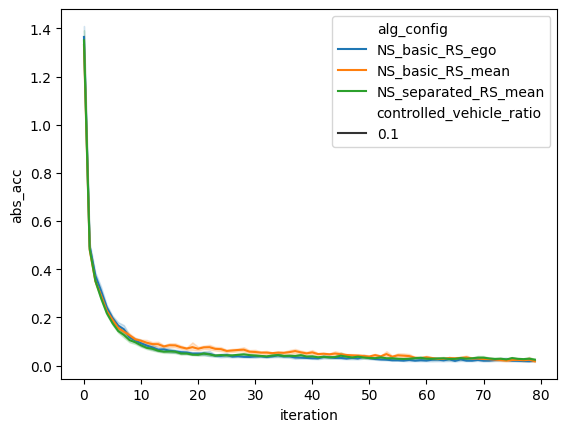

In [53]:
data = grouped_df[grouped_df["controlled_flag"] == 0]
sns.lineplot(data[data["controlled_vehicle_ratio"] == 0.1], x="iteration", y="abs_acc", hue="alg_config", style="controlled_vehicle_ratio")

### controlled vehicles

<Axes: xlabel='iteration', ylabel='speed_diff'>

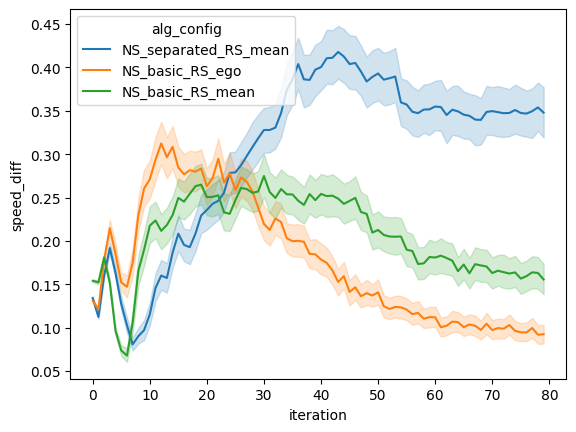

In [56]:
sns.lineplot(df_detail[(df_detail["controlled_flag"]==1)], x="iteration", y="speed_diff", hue="alg_config")